# 基于 NIM 建构多模态 AI-Agent (代码 demo+练习)

本次课程将着重介绍一下内容:

* 多模态模型基于 NIM 的调用方式
* 基于 NIM 接口实现 Phi-3-Vision 的推理实践
* 基于 Gradio 框架建立前端互动界面

## 申请NIM的API Key，来调用NIM的计算资源

进入[ai.nvidia.com](ai.nvidia.com),点击Try Now按钮，选择您要使用的模型并点击，进入后点击**Get API Key**按钮，生成一个秘钥

![](https://v.png.pub/imgs/2024/07/01/72fa333bb5bee55b.png)

# 练习Demo1：基于NIM与langchain实现多模态RAG

### 第一步, 导入工具包

本次实验主要需要三个工具包:

* `langchain_nvidia_ai_endpoint`: 用来调用nvidia nim的计算资源
* `langchain`: 用来构建对话链, 将智能体的各个组件串联起来
* `base64`: 因为本实验是构建多模态的智能体, 需要base64来对图像进行编解码

In [1]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableLambda
from langchain.schema.runnable.passthrough import RunnableAssign
from langchain_core.runnables import RunnableBranch
from langchain_core.runnables import RunnablePassthrough

from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

import os
import base64
import matplotlib.pyplot as plt
import numpy as np

将上面准备好自己的API-KEY秘钥粘贴在此处进行替换, 当我们向服务器发送计算请求时, 需要用到

In [2]:
os.environ["NVIDIA_API_KEY"] = ""

查看当前可以使用的模型

In [3]:
ChatNVIDIA.get_available_models()

[Model(id='google/deplot', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/vlm/google/deplot', aliases=['ai-google-deplot', 'playground_deplot', 'deplot'], supports_tools=False, base_model=None),
 Model(id='microsoft/phi-3-mini-128k-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-phi-3-mini'], supports_tools=False, base_model=None),
 Model(id='microsoft/phi-3-small-8k-instruct', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-phi-3-small-8k-instruct'], supports_tools=False, base_model=None),
 Model(id='writer/palmyra-med-70b-32k', model_type='chat', client='ChatNVIDIA', endpoint=None, aliases=['ai-palmyra-med-70b-32k'], supports_tools=False, base_model=None),
 Model(id='liuhaotian/llava-v1.6-mistral-7b', model_type='vlm', client='ChatNVIDIA', endpoint='https://ai.api.nvidia.com/v1/stg/vlm/community/llava16-mistral-7b', aliases=['ai-llava16-mistral-7b', 'community/llava16-mistral-7b', 'liuhaotian/llava16-mi

### 第二步, 利用Microsoft Phi 3 vision 来解析图片数据

将图片进行编解码

In [4]:
def image2b64(image_file):
    with open(image_file, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()
        return image_b64

image_b64 = image2b64("/home/nvidia/aws_hackathon_demo/pikachu_moves_level_up.png")

# image_b64 = image2b64("eco-good-bad-chart.png")

查看图片

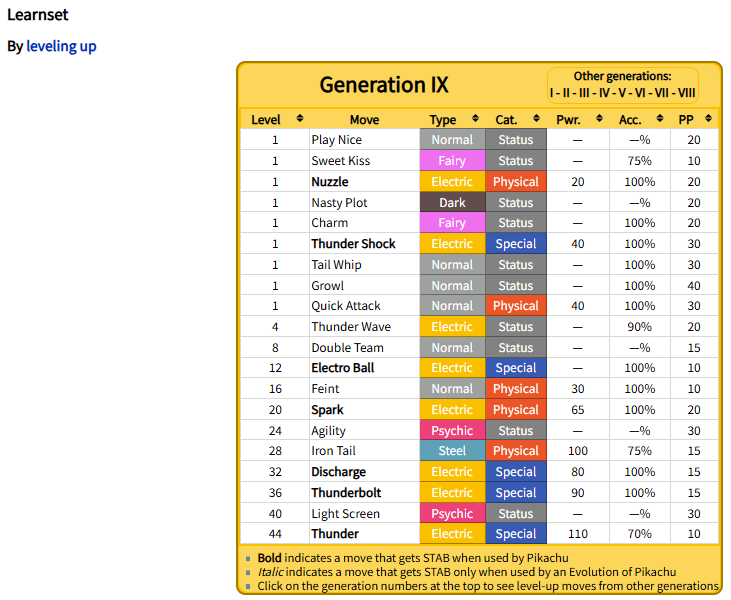

In [5]:
from PIL import Image
display(Image.open("/home/nvidia/aws_hackathon_demo/pikachu_moves_level_up.png"))

将编码后的图像按照格式给到Microsoft Phi 3 vision , 利用其强大能力解析图片中的数据

In [6]:
chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64}" />')
print(result.content)

Certainly! Below is the markdown table converted from the image provided:

```markdown
| Level | Move         | Type     | Cat.     | Pwr. | Acc. | PP  |
|-------|--------------|----------|----------|------|------|-----|
| 1     | Play Nice    | Normal   | Status   | -    | -%   | 20  |
| 1     | Sweet Kiss   | Fairy    | Status   | -    | 75%  | 10  |
| 1     | Nuzzle       | Electric | Physical | 20   | 100% | 20  |
| 1     | Nasty Plot   | Dark     | Status   | -    | -%   | 20  |
| 1     | Charm        | Fairy    | Status   | -    | 100% | 20  |
| 1     | Thunder Shock| Electric | Special  | 40   | 100% | 30  |
| 1     | Tail Whip    | Normal   | Status   | -    | 100% | 30  |
| 1     | Growl        | Normal   | Status   | -    | 100% | 40  |
| 1     | Quick Attack | Normal   | Physical | 40   | 100% | 30  |
| 4     | Thunder Wave | Electric | Status   | -    | 90%  | 20  |
| 8     | Double Team  | Normal   | Status   | -    | -%   | 15  |
| 12    | Electro Ball | Electric | Specia

In [7]:
test_doc = result.content

In [8]:
test_doc

'Certainly! Below is the markdown table converted from the image provided:\n\n```markdown\n| Level | Move         | Type     | Cat.     | Pwr. | Acc. | PP  |\n|-------|--------------|----------|----------|------|------|-----|\n| 1     | Play Nice    | Normal   | Status   | -    | -%   | 20  |\n| 1     | Sweet Kiss   | Fairy    | Status   | -    | 75%  | 10  |\n| 1     | Nuzzle       | Electric | Physical | 20   | 100% | 20  |\n| 1     | Nasty Plot   | Dark     | Status   | -    | -%   | 20  |\n| 1     | Charm        | Fairy    | Status   | -    | 100% | 20  |\n| 1     | Thunder Shock| Electric | Special  | 40   | 100% | 30  |\n| 1     | Tail Whip    | Normal   | Status   | -    | 100% | 30  |\n| 1     | Growl        | Normal   | Status   | -    | 100% | 40  |\n| 1     | Quick Attack | Normal   | Physical | 40   | 100% | 30  |\n| 4     | Thunder Wave | Electric | Status   | -    | 90%  | 20  |\n| 8     | Double Team  | Normal   | Status   | -    | -%   | 15  |\n| 12    | Electro Ball | 

In [9]:
test_doc = "The moves listed in the following table are those that Pikachu can learn through leveling up.\n" + test_doc
print(test_doc)

The moves listed in the following table are those that Pikachu can learn through leveling up.
Certainly! Below is the markdown table converted from the image provided:

```markdown
| Level | Move         | Type     | Cat.     | Pwr. | Acc. | PP  |
|-------|--------------|----------|----------|------|------|-----|
| 1     | Play Nice    | Normal   | Status   | -    | -%   | 20  |
| 1     | Sweet Kiss   | Fairy    | Status   | -    | 75%  | 10  |
| 1     | Nuzzle       | Electric | Physical | 20   | 100% | 20  |
| 1     | Nasty Plot   | Dark     | Status   | -    | -%   | 20  |
| 1     | Charm        | Fairy    | Status   | -    | 100% | 20  |
| 1     | Thunder Shock| Electric | Special  | 40   | 100% | 30  |
| 1     | Tail Whip    | Normal   | Status   | -    | 100% | 30  |
| 1     | Growl        | Normal   | Status   | -    | 100% | 40  |
| 1     | Quick Attack | Normal   | Physical | 40   | 100% | 30  |
| 4     | Thunder Wave | Electric | Status   | -    | 90%  | 20  |
| 8     | Doubl

In [10]:
image_b64_TM_1 = image2b64("/home/nvidia/aws_hackathon_demo/pikachu_moves_TM_1.png")
chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_TM_1}" />')
print(result.content)
test_doc = test_doc + "\nThe moves listed in the following table are those that Pikachu can learn through TMs.\n" + result.content
image_b64_TM_2 = image2b64("/home/nvidia/aws_hackathon_demo/pikachu_moves_TM_2.png")
chart_reading = ChatNVIDIA(model="microsoft/phi-3-vision-128k-instruct")
result = chart_reading.invoke(f'Generate underlying data table of the figure below, : <img src="data:image/png;base64,{image_b64_TM_2}" />')
print(result.content)
test_doc = test_doc + "\nThe moves listed in the following table are those that Pikachu can learn through TMs.\n" + result.content

Certainly! Below is the markdown table converted from the image provided:

```markdown
| TM     | Move          | Type     | Cat. | Pwr. | Acc. | PP |
|--------|---------------|----------|------|------|------|----|
| TM001  | Take Down     | Normal   | Physical | 90 | 85% | 20 |
| TM002  | Charm         | Fairy    | Status | 100% | 20 |
| TM003  | Fake Tears    | Dark     | Status | 100% | 20 |
| TM004  | Agility       | Psychic  | Status | -% | 30 |
| TM007  | Protect       | Normal   | Status | -% | 10 |
| TM018  | Thief         | Dark     | Physical | 60 | 100% | 25 |
| TM019  | Disarming Voice | Fairy  | Special | 40 | -% | 15 |
| TM020  | Trailblaze    | Grass    | Physical | 50 | 100% | 20 |
| TM023  | Charge Beam   | Electric | Special | 50 | 90% | 10 |
| TM025  | Facade        | Normal   | Physical | 70 | 100% | 20 |
| TM032  | Swift         | Normal   | Special | 60 | -% | 20 |
| TM037  | Draining Kiss | Fairy    | Special | 50 | 100% | 10 |
| TM043  | Fling         | Dark    

In [11]:
with open('/home/nvidia/aws_hackathon_demo/pikachu_moves.txt', 'w', encoding='utf-8') as file:
    # 将字符串写入文件
    file.write(test_doc)

print("字符串已写入文件。")

字符串已写入文件。


### 第三步, 实现RAG检索流程

In [12]:
from operator import itemgetter
from langchain.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.text_splitter import CharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA
import faiss

In [13]:
import os
from tqdm import tqdm
from pathlib import Path

# Here we read in the text data and prepare them into vectorstore
ps = os.listdir("/home/nvidia/aws_hackathon_demo/")
data = []
sources = []
for p in ps:
    if p.endswith('.txt'):
        path2file="/home/nvidia/aws_hackathon_demo/"+p
        with open(path2file,encoding="utf-8") as f:
            lines=f.readlines()
            for line in lines:
                if len(line)>=1:
                    data.append(line)
                    sources.append(path2file)

In [14]:
documents=[d for d in data if d != '\n']
len(data), len(documents), data[0]

(177,
 163,
 'Here comes all the moves of Pikachu, firstly the moves can be learned by leveling up.\n')

In [15]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embedder = NVIDIAEmbeddings(model="NV-Embed-QA")

In [16]:
# 只需要执行一次，后面可以重读已经保存的向量存储
text_splitter = CharacterTextSplitter(chunk_size=400, separator=" ")
docs = []
metadatas = []

for i, d in enumerate(documents):
    splits = text_splitter.split_text(d)
    #print(len(splits))
    docs.extend(splits)
    metadatas.extend([{"source": sources[i]}] * len(splits))

store = FAISS.from_texts(docs, embedder , metadatas=metadatas)
store.save_local('/home/nvidia/aws_hackathon_demo/nv_embedding')

In [17]:
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

In [19]:
retriever = store.as_retriever()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Answer solely based on the following context:\n<Documents>\n{context}\n</Documents>",
        ),
        ("user", "{question}"),
    ]
)

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("Can pikachu learn surf? By leveling up or by TMs?")

'The provided context does not mention the specific move "surf" being learned by Pikachu through leveling up or TMs. Therefore, it cannot be determined whether Pikachu can learn surf by leveling up or by TMs based on the provided information.'

## 问题反思
1. 只根据文档回答问题，会出现模型脑子转不过弯的情况
2. 文档是读图之后的结果拼接生成的，读图结果每次会有一些细微差别，没有办法做特别精准的处理把没用的文本去掉。
3. 前端没做出来，我们队的工作主要集中在整理资料，写爬虫爬取百科类网页，总是被ban。
4. 宝可梦配队资料直接读热门博主的视频摘要。靠B站上面呼唤机器人得到的结果不够精准，总结的内容不包含配队的关键优缺点信息，用作队伍介绍更好。

## 解决办法
1. 拿到文档之后转换文档格式，全部一点一点处理成问答型的文档
2. 保证读图结果不含非重要信息，最重要的是图片裁剪的够精准
3. 下次组队需要找更多的人，最主要是要找一个不排斥Py技术栈的前端大佬
4. 仍然需要其它工具帮助整理视频中的关键信息，提高效率。

## 最终目标
1. 分析宝可梦配招是否合法。
2. 若合法，分析每个配招的优缺点。
3. 分析宝可梦配队合理性。
4. 分别根据每个宝可梦配招考虑宝可梦配队对应战术。
5. 带入 Pokemmo 市场数据分析组队成本